# Collider Bias Example: Education, Wage, and Investments

This notebook shows the effect of collider bias in causal inference. 

**Variables:**
- Education (E): Years of education (continuous)
- Wage (W): Annual wage (continuous)
- Investments (I): Amount invested (continuous)

**Causal structure:**
- Education increases Wage (E → W)
- Both Education and Wage increase Investments (E → I ← W)

In [31]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import warnings

np.random.seed(123)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

## 1. Define the true causal mechanisms

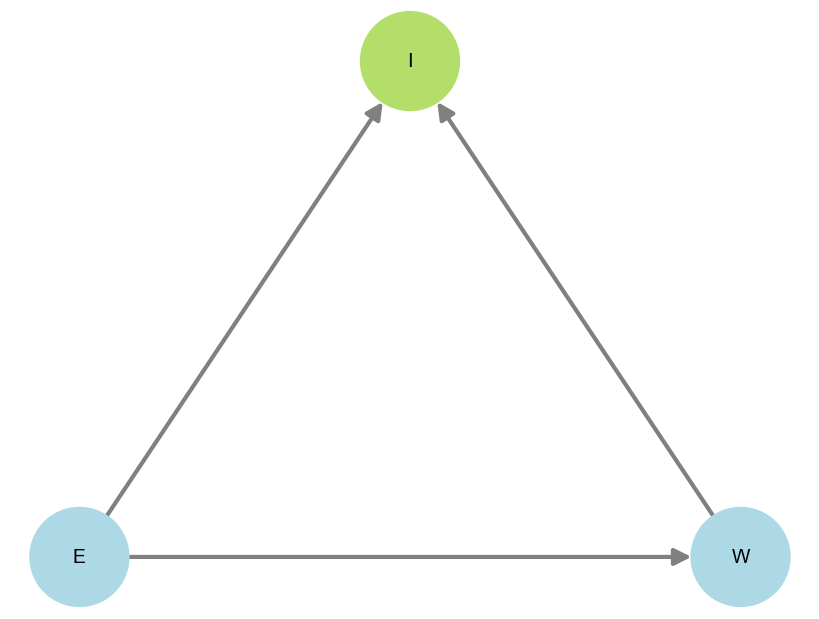

In [40]:
# The DAG

nodes = ["E", "W", "I"]
edges = [("E", "W"), ("E", "I"), ("W", "I")]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Position nodes in a diamond layout
pos = {"E": (0, 0), "W": (1, 0), "I": (0.5, 0.5),}
node_colors = {"E": 'lightblue', "W": 'lightblue', "I": '#b3de69'}
node_color_list = [node_colors[node] for node in G.nodes()]

basic_settings = {
    "node_color": node_color_list, "node_size": 5000,
    "font_size": 14,
    "linewidths": 1.5,
    "arrowsize": 25,
    "width": 3,
    "edge_color": 'gray',
    "arrows": True,
}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, **basic_settings)

In [45]:
# The equations

TRUE_CAUSAL_EFFECT = 20.0

def wages_ground_truth(education):
    return 10000 + TRUE_CAUSAL_EFFECT * education + np.random.normal(0, 80, education.shape)

def investments_ground_truth(education, wage):
    return 1000 + 50 * education + 2 * wage + np.random.normal(0, 80, education.shape)

## 2. Generate data

In [46]:
n_samples = 200

education = np.random.normal(loc=10, scale=2, size=n_samples)
wages = wages_ground_truth(education)
investments = investments_ground_truth(education, wages)

data = pd.DataFrame({
    'education': education,
    'wage': wages,
    'investments': investments
})

## 3. Train regression Models

We'll fit two models:

- Wage ~ Education (does not condition on Investments)
- Wage ~ Education + Investments (conditions on the collider)

In [47]:
# Standardize variables for MCMC
std_data = data.copy()
std_data['education_std'] = (data['education'] - data['education'].mean()) / data['education'].std()
std_data['wage_std'] = (data['wage'] - data['wage'].mean()) / data['wage'].std()
std_data['investments_std'] = (data['investments'] - data['investments'].mean()) / data['investments'].std()

# Wage ~ Education 
with pm.Model() as model_unbiased:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    mu = alpha + beta_edu * std_data['education_std']
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=std_data['wage_std'])
    trace_unbiased = pm.sample(3000, tune=1000, return_inferencedata=True)

# Wage ~ Education + Investments
with pm.Model() as model_collider:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    beta_inv = pm.Normal('beta_inv', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    mu = alpha + beta_edu * std_data['education_std'] + beta_inv * std_data['investments_std']
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=std_data['wage_std'])
    trace_collider = pm.sample(3000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_edu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_edu, beta_inv, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


## 4. Compare Results

Let's compare the posterior distributions of the education effect from both models and see the collider bias.

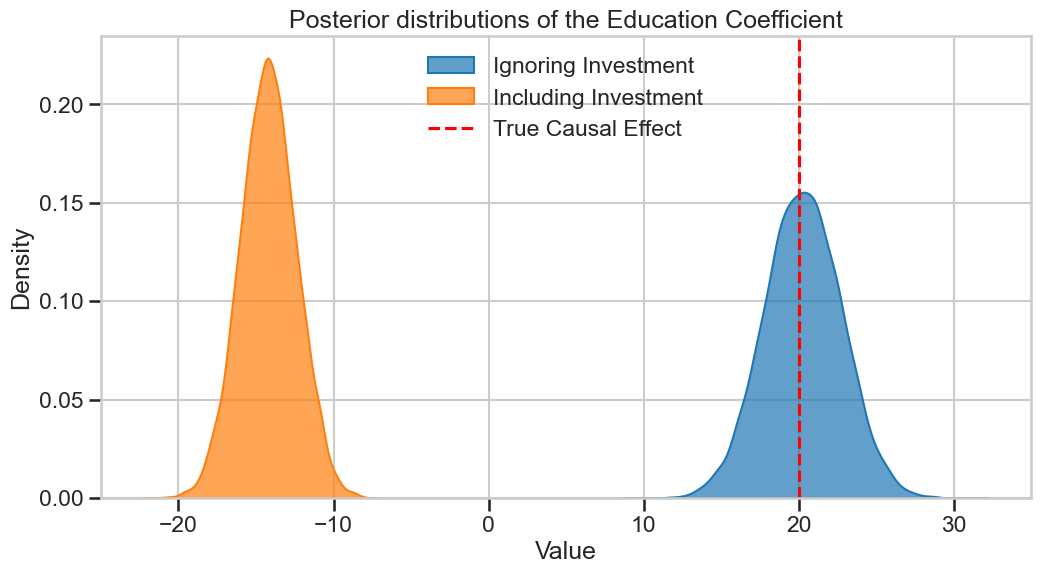

Unbiased model effect estimate: 20.26 (95% CI: [15.40, 25.15])
Collider model effect estimate: -14.21 (95% CI: [-17.77, -10.70])
True causal effect: 20.00


In [50]:
# Extract posterior samples
unbiased_effect = trace_unbiased.posterior['beta_edu'].values.flatten()
collider_effect = trace_collider.posterior['beta_edu'].values.flatten()

# Rescale to original units
std_wage = data['wage'].std()
std_edu = data['education'].std()
unbiased_effect_rescaled = unbiased_effect * std_wage / std_edu
collider_effect_rescaled = collider_effect * std_wage / std_edu

plt.figure(figsize=(12, 6))
sns.kdeplot(unbiased_effect_rescaled, fill=True, label='Ignoring Investment', alpha=0.7)
sns.kdeplot(collider_effect_rescaled, fill=True, label='Including Investment', alpha=0.7)
plt.axvline(x=TRUE_CAUSAL_EFFECT, color='red', linestyle='--', label='True Causal Effect')
plt.title('Posterior distributions of the Education Coefficient')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

print("Unbiased model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
    unbiased_effect_rescaled.mean(),
    np.percentile(unbiased_effect_rescaled, 2.5),
    np.percentile(unbiased_effect_rescaled, 97.5)
))

print("Collider model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
    collider_effect_rescaled.mean(),
    np.percentile(collider_effect_rescaled, 2.5),
    np.percentile(collider_effect_rescaled, 97.5)
))

print("True causal effect: {:.2f}".format(TRUE_CAUSAL_EFFECT))